In [998]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split


# CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization,LeakyReLU
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import utils,losses
# pre-trained
from tensorflow.keras.applications import VGG19,EfficientNetB4


import tensorflow as tf

# some more image preprocessing
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip
from tensorflow.keras.layers import RandomHeight, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomWidth, RandomZoom
from tensorflow.keras import layers


import imgaug.augmenters as iaa


# import skimage
import cv2

# from PIL.ExifTags import TAGS
# from PIL import ExifTags
from PIL import Image

import glob


# from os import listdir
# from os.path import isfile, join

# import keras.applications

# metrics
# from sklearn.metrics import plot_confusion_matrix,ConfusionMatrixDisplay, confusion_matrix

#
import gc

# reloads module to update
import universal_methods
import importlib
importlib.reload(universal_methods)
# .py file with universal methods, that I use more than one time in this project
from universal_methods import Universal

# For reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [5]:
X,y,class_labels=Universal().get_images(size=150)
class_labels

Found 2041 images belonging to 2 classes.


['fake', 'real']

In [6]:
X_train_temp,X_test,y_train_temp,y_test=train_test_split(X,y,random_state=42,stratify=y,test_size=0.1)
X_train,X_val,y_train,y_val=train_test_split(X_train_temp,y_train_temp,random_state=42,stratify=y_train_temp,test_size=0.11)
X_train.shape,y_train.shape,X_val.shape,y_val.shape, X_test.shape,y_test.shape

((1634, 150, 150, 3),
 (1634,),
 (202, 150, 150, 3),
 (202,),
 (205, 150, 150, 3),
 (205,))

----
## Data Augmentation
First of all, let's try the vary basic augmentation technics, like resizing, rotation and flip. 

In [4]:
IMG_SIZE = 120
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-09 14:29:42.245016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-09 14:29:42.245488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


EDIT! If you have less number of training pairs, the results might not be good be because the model might overfit. We can increase the size of the dataset by applying random transformations on the images. We can change the color properties like hue, saturation, brightness, etc of the input images. We can also apply transformations such as rotation, scale, and flipping. For the transformations which change the location of the pixels, the segmentation image should also be transformed the same way.

In [5]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
model_git=Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])
model_git.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_git.add(Conv2D(8, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_git.add(Conv2D(16, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_git.add(Conv2D(16, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
model_git.add(Flatten())
model_git.add(Dropout(0.5))
model_git.add(Dense(16,kernel_regularizer =tf.keras.regularizers.l2(l=0.01)))
model_git.add(LeakyReLU(alpha=0.1))
model_git.add(Dropout(0.5))
model_git.add(Dense(1, activation = 'sigmoid'))
model_git.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
history_git=model_git.fit(X_train, y_train, batch_size = 128, epochs = 25, verbose = 1, validation_data = (X_val, y_val))


As we can see, it didn't work well. Performance of the model decreased - it struggles to find any signal which it was able to catch before augmentations. Second step would be to try some channel and color balance augmentations - my goal is to find the proper set of technics to highlight the skewed parts of images to the model. 

----
#### 2nd approach


In [35]:
import imgaug as ia
import imgaug.augmenters as iaa



ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = X_test[1]

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    # iaa.Crop(percent=(0, 0.1)), # random crops
    # # Small gaussian blur with random sigma between 0 and 0.5.
    # # But we only blur about 50% of all images.
    # iaa.Sometimes(
    #     0.5,
    #     iaa.GaussianBlur(sigma=(0, 0.5))
    # ),
    # # Strengthen or weaken the contrast in each image.
    # iaa.LinearContrast((0.75, 1.5)),
    # # Add gaussian noise.
    # # For 50% of all images, we sample the noise once per pixel.
    # # For the other 50% of all images, we sample the noise per pixel AND
    # # channel. This can change the color (not only brightness) of the
    # # pixels.
    # iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # # Make some images brighter and some darker.
    # # In 20% of all cases, we sample the multiplier once per channel,
    # # which can end up changing the color of the images.
    # iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # # Apply affine transformations to each image.
    # # Scale/zoom them, translate/move them, rotate them and shear them.
    # iaa.Affine(
    #     scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
    #     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    #     rotate=(-25, 25),
    #     shear=(-8, 8)
    # )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)


In [33]:
images_aug.shape

(150, 150, 3)

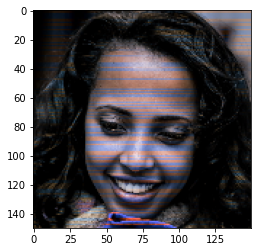

In [36]:
plt.imshow(images_aug)


In [3]:
# 2. Image Augmentation
augmentation = iaa.Sequential([
    # 1. Flip
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    # 2. Affine
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-30, 30),
               scale=(0.5, 1.5)),
    # 3. Multiply
    iaa.Multiply((0.8, 1.2)),
    # 4. Linearcontrast
    iaa.LinearContrast((0.6, 1.4)),
    # Perform methods below only sometimes
    iaa.Sometimes(0.5,
        # 5. GaussianBlur
        iaa.GaussianBlur((0.0, 3.0))
        )
])

In [8]:
# 3. Show Images
# for _ in range(1,10):
augmented_images = augmentation(images=X_train[1])
for img in augmented_images:
        cv2.imshow("Image", img)
        # cv2.waitKey(0)

In [10]:
augmentation(images=X_train[1])

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

----
https://www.kaggle.com/code/aleksandradeis/data-augmentation-packages-overview/notebook

I'll create a function to get examples of different augmentations and run it through each type of fake images (easy, medium and hard). In theory, that will help to find the best set to highlight pixel structure skews to the model.

In [953]:
def augment_sample(images):
    # image=X_train[0]
    res=[]
    for num in range(len(images)):
        res.append(images[num])
        res.append(iaa.ChannelShuffle(1).augment_image(images[num]))
        res.append(iaa.AdditiveGaussianNoise(scale=(100, 0.4*255)).augment_image(images[num]))
        res.append(iaa.Solarize(0.8, threshold=40).augment_image(images[num]))
        res.append(iaa.JpegCompression(compression=(98, 99)).augment_image(images[num]))
        res.append(iaa.Invert(0.5).augment_image(images[num]))
        res.append(iaa.BlendAlpha(0.5, iaa.Grayscale(1.0)).augment_image(images[num]))
        res.append(iaa.BlendAlphaSimplexNoise(iaa.EdgeDetect(1),upscale_method="nearest").augment_image(images[num]))
        res.append(iaa.MeanShiftBlur().augment_image(images[num]))
        res.append(iaa.RandAugment(n=2, m=9).augment_image(images[num]))
        res.append(iaa.AddToHueAndSaturation((-100, 0), per_channel=True).augment_image(images[num]))
        res.append(iaa.SigmoidContrast(gain=(2, 10), cutoff=(0.8, 0.9), per_channel=True).augment_image(images[num]))
        res.append(iaa.AllChannelsCLAHE(clip_limit=(1, 9), per_channel=True).augment_image(images[num]))
        res.append(iaa.CLAHE().augment_image(images[num]))
        res.append(iaa.Sharpen(alpha=(0.7, 1.0), lightness=(0.75, 1.5)).augment_image(images[num]))
        res.append(iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5)).augment_image(images[num]))
        res.append(iaa.EdgeDetect(alpha=(0.7, 1.0)).augment_image(images[num]))
        res.append(iaa.DirectedEdgeDetect(alpha=(0.95), direction=(0.1, 1.0)).augment_image(images[num]))
        
    return res
# images_aug
# plt.imshow(g_noice[0])


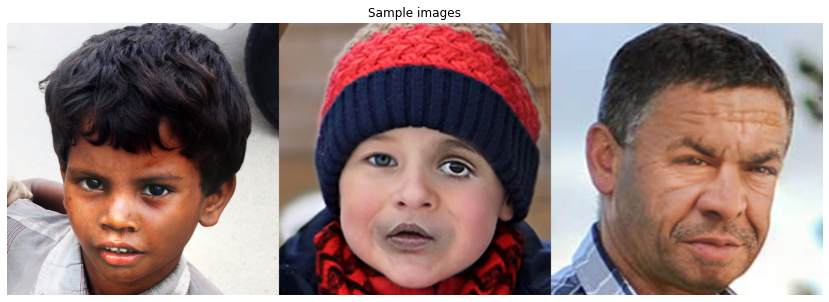

In [956]:
samples=Universal().generate_samples(1)
plt.figure(figsize=(15,5))
plt.axis('off')
plt.title('Sample images')
plt.imshow(np.hstack(samples))


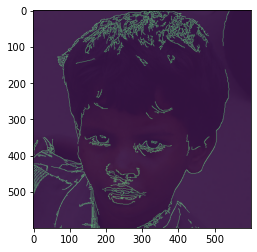

In [961]:
plt.imshow(iaa.Canny(alpha=(0.5, 1.0), sobel_kernel_size=[3, 7]).augment_image(samples[0]))

In [962]:
r=augment_sample(samples)

Here is one of the examples, that shows how proper augmentation can highlight "faked" part of th image.

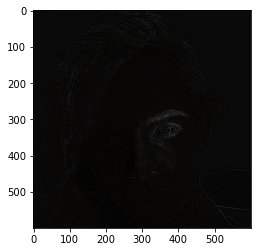

In [834]:
plt.imshow(iaa.EdgeDetect(alpha=(0.7, 1.0)).augment_image(samples[1]))

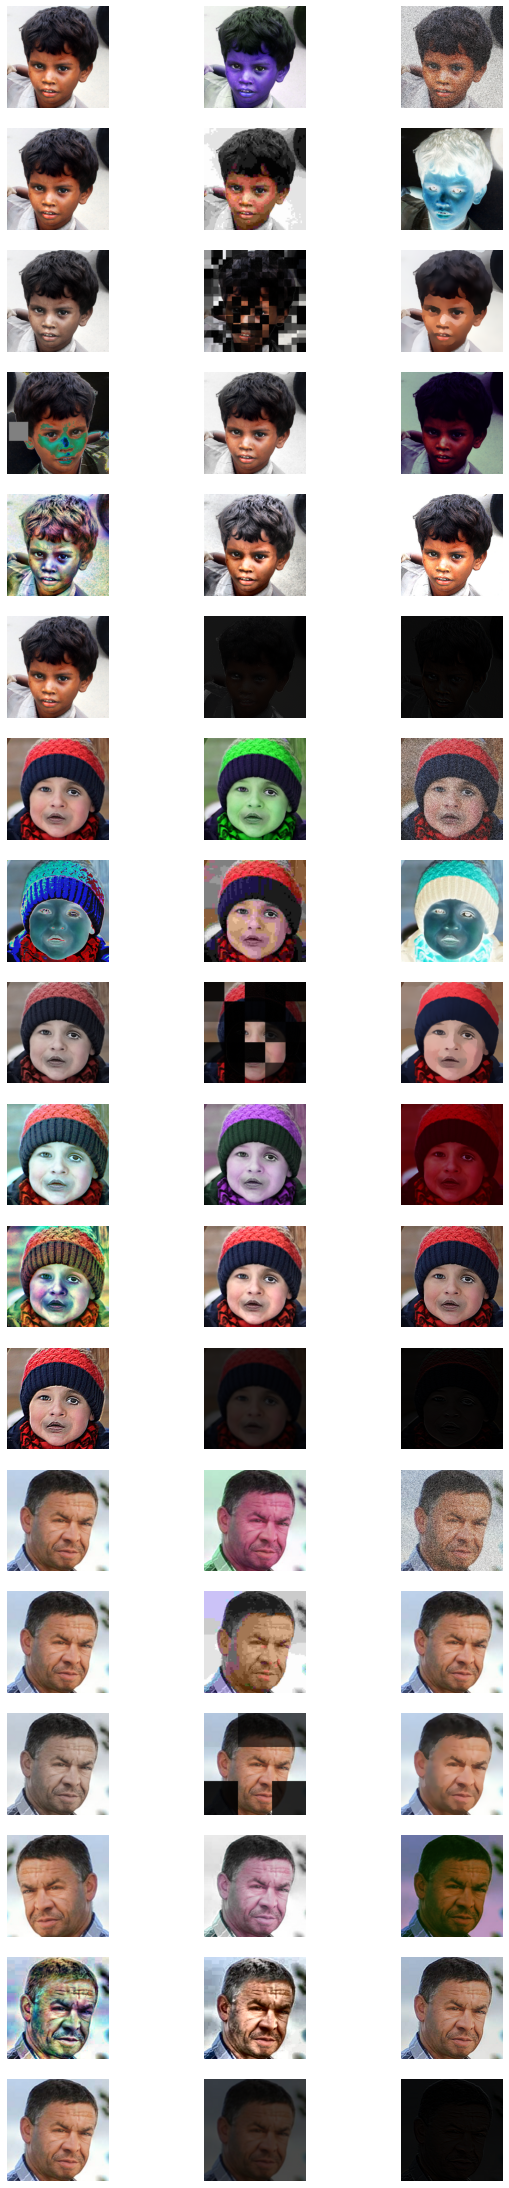

In [966]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 40))
columns = 3
rows = 18
for i in range(1, columns*rows+1):
    img = r[i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [163]:
# Universal().plot_samples(samples,9,3,"Per category sample",savename="samples_plot_aug");

Here we have 3 random images for each class. Now let's try to find best augmentation technics.

In [ ]:
images_aug = [image_rotated[0], image_noise[0], image_crop[0], image_hue[0], image_trans[0], image_coarse[0]]

# plot augmentation examples
plt.figure(figsize=(15,5))
plt.axis('off')
plt.imshow(np.hstack(images_aug))
plt.title('Sample augmentations')

----

In [22]:
# use imageio library to read the image (alternatively you can use OpenCV cv2.imread() function)
image = X_test[2]

# initialize the augmenters for demo
rotate = iaa.Affine(rotate=(-25, 25)) # rotate image
gaussian_noise = iaa.AdditiveGaussianNoise(scale=(10, 60)) # add gaussian noise
crop = iaa.Crop(percent=(0, 0.4)) # crop image
hue = iaa.AddToHueAndSaturation((-60, 60))  # change their color
elastic_trans = iaa.ElasticTransformation(alpha=90, sigma=9) # water-like effect
coarse_drop = iaa.CoarseDropout((0.01, 0.1), size_percent=0.01)# set large image areas to zero

Text(0.5, 1.0, 'Sample augmentations')

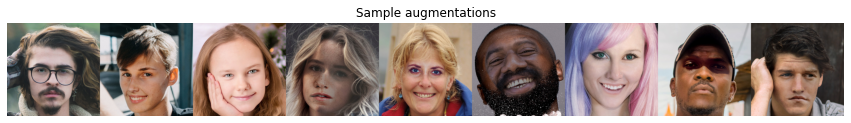

In [147]:
# get augmented images
image_rotated = rotate.augment_images([image])
image_noise = gaussian_noise.augment_images([image])
image_crop = crop.augment_images([image])
# image_hue = hue.augment_images([image])
image_trans = elastic_trans.augment_images([image])
image_coarse = coarse_drop.augment_images([image])


# create an array of augmented images for the demo
images_aug = [image_rotated[0], image_noise[0], image_crop[0], image_hue[0], image_trans[0], image_coarse[0]]

# plot augmentation examples
plt.figure(figsize=(15,5))
plt.axis('off')
plt.imshow(np.hstack(images_aug))
plt.title('Sample augmentations')

In [970]:
def augment_sample(images):
    # image=X_train[0]
    res=[]
    for num in range(len(images)):
        res.append(images[num])
        res.append(iaa.ChannelShuffle(1).augment_image(images[num]))
        res.append(iaa.AdditiveGaussianNoise(scale=(100, 0.4*255)).augment_image(images[num]))
        res.append(iaa.Solarize(0.8, threshold=40).augment_image(images[num]))
        res.append(iaa.JpegCompression(compression=(98, 99)).augment_image(images[num]))
        res.append(iaa.Invert(0.5).augment_image(images[num]))
        res.append(iaa.BlendAlpha(0.5, iaa.Grayscale(1.0)).augment_image(images[num]))
        res.append(iaa.BlendAlphaSimplexNoise(iaa.EdgeDetect(1),upscale_method="nearest").augment_image(images[num]))
        res.append(iaa.MeanShiftBlur().augment_image(images[num]))
        res.append(iaa.RandAugment(n=2, m=9).augment_image(images[num]))
        res.append(iaa.AddToHueAndSaturation((-100, 0), per_channel=True).augment_image(images[num]))
        res.append(iaa.SigmoidContrast(gain=(2, 10), cutoff=(0.8, 0.9), per_channel=True).augment_image(images[num]))
        res.append(iaa.AllChannelsCLAHE(clip_limit=(1, 9), per_channel=True).augment_image(images[num]))
        res.append(iaa.CLAHE().augment_image(images[num]))
        res.append(iaa.Sharpen(alpha=(0.7, 1.0), lightness=(0.75, 1.5)).augment_image(images[num]))
        res.append(iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5)).augment_image(images[num]))
        res.append(iaa.EdgeDetect(alpha=(0.7, 1.0)).augment_image(images[num]))
        res.append(iaa.DirectedEdgeDetect(alpha=(0.95), direction=(0.1, 1.0)).augment_image(images[num]))
        
    return res

In [990]:
img = Image.fromarray((255*X_train[1]).astype(np.uint8).transpose(1, 2, 0))


TypeError: Cannot handle this data type: (1, 1, 150), |u1

In [985]:
X_r,y_r,class_labels_r=Universal().get_images(size=150)


Found 2041 images belonging to 2 classes.


In [999]:
data = 255 * X_train
img = data.astype(np.uint8)

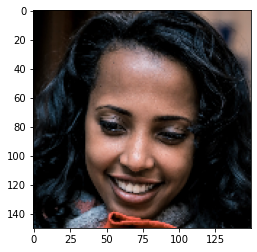

In [997]:
plt.imshow(img)

In [1019]:
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = img

seq = iaa.Sequential([

    iaa.OneOf(
    iaa.ChannelShuffle(1),
    iaa.AdditiveGaussianNoise(scale=(100, 0.4*255))),
    iaa.Solarize(0.8, threshold=40),
    iaa.JpegCompression(compression=(98, 99)),
    iaa.Invert(0.5),
    iaa.BlendAlpha(0.5, iaa.Grayscale(1.0))
    # iaa.OneOf(
    # iaa.BlendAlphaSimplexNoise(iaa.EdgeDetect(1),upscale_method="nearest"),
    # iaa.MeanShiftBlur(),
    # iaa.RandAugment(n=2, m=9),
    # iaa.AddToHueAndSaturation((-100, 0), per_channel=True),
    # iaa.SigmoidContrast(gain=(2, 10), cutoff=(0.8, 0.9), per_channel=True),
    # iaa.AllChannelsCLAHE(clip_limit=(1, 9), per_channel=True)),
    # iaa.OneOf(
    # iaa.CLAHE(),
    # iaa.Sharpen(alpha=(0.7, 1.0), lightness=(0.75, 1.5)),
    # iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5)),
    # iaa.EdgeDetect(alpha=(0.7, 1.0)),
    # iaa.DirectedEdgeDetect(alpha=(0.95), direction=(0.1, 1.0)))
], random_order=True) # apply augmenters in random order


images_aug = seq(images=images)


TypeError: SeedSequence expects int or sequence of ints for entropy not AdditiveGaussianNoise(name=UnnamedAdditiveGaussianNoise, parameters=[Normal(loc=Deterministic(int 0), scale=Uniform(Deterministic(int 100), Deterministic(float 102.00000000))), Deterministic(int 0)], deterministic=False)

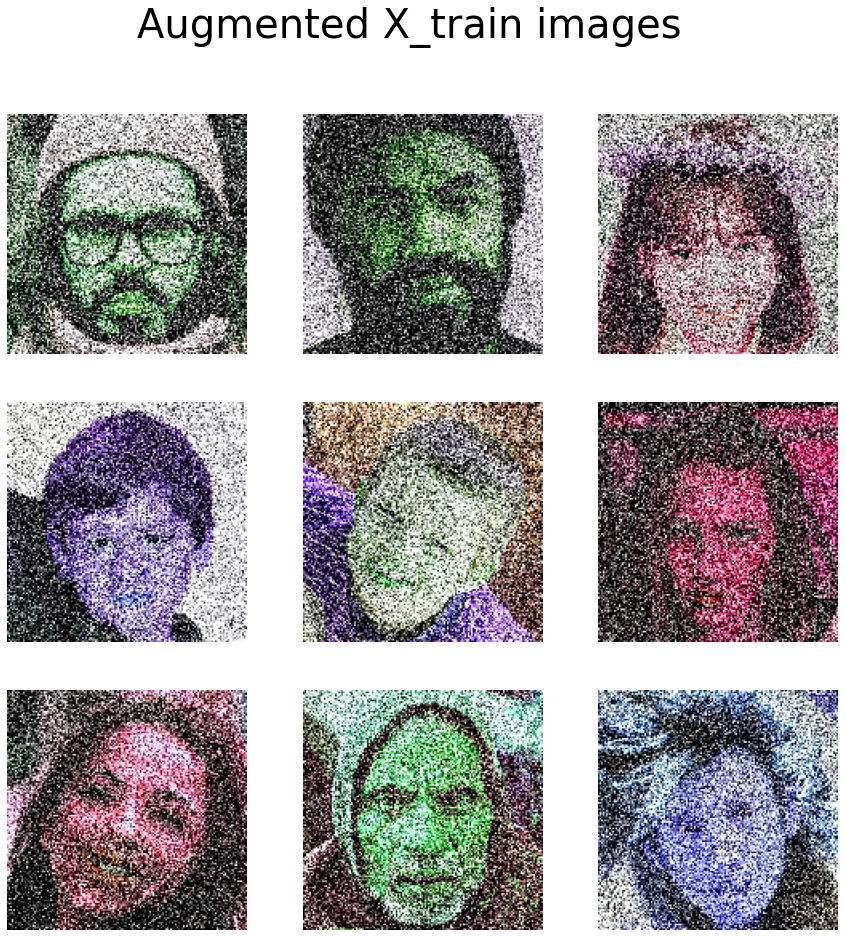

<Figure size 432x288 with 0 Axes>

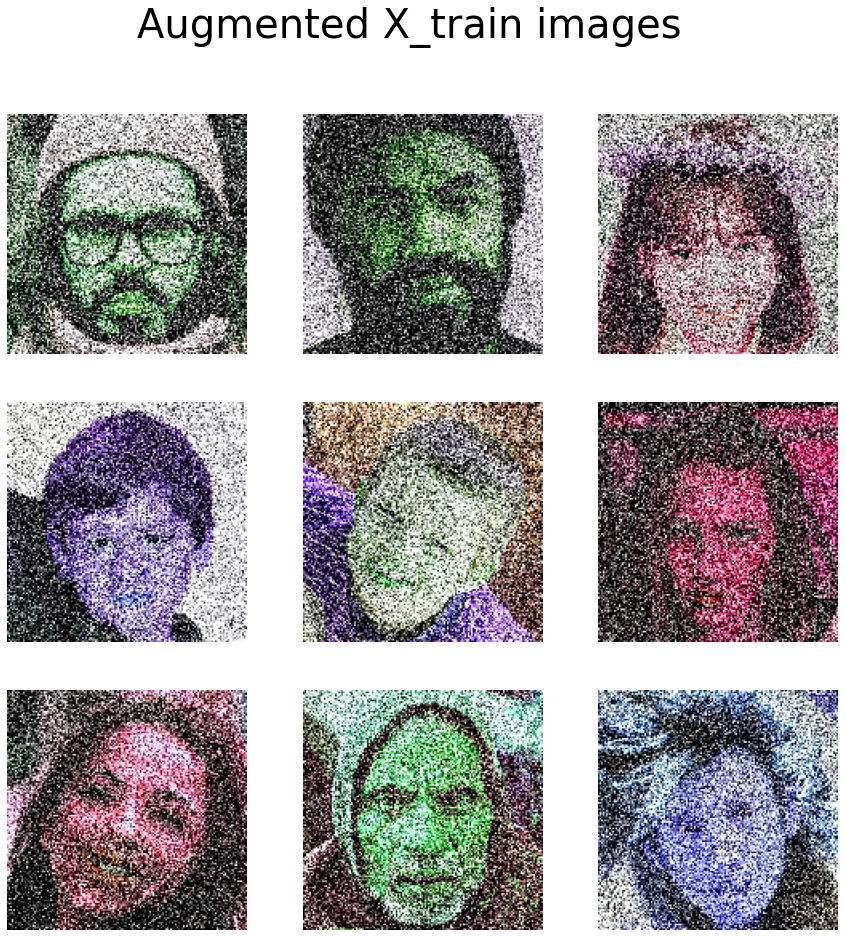

In [1018]:
Universal().plot_samples(images_aug,9,3,"Augmented X_train","x_train_aug")

In [ ]:
iaa.ChannelShuffle(1),
iaa.AdditiveGaussianNoise(scale=(100, 0.4*255)),
iaa.Solarize(0.8, threshold=40),
iaa.JpegCompression(compression=(98, 99)),
iaa.Invert(0.5),
iaa.BlendAlpha(0.5, iaa.Grayscale(1.0)),
iaa.BlendAlphaSimplexNoise(iaa.EdgeDetect(1),upscale_method="nearest"),
iaa.MeanShiftBlur(),
iaa.Sharpen(alpha=(0.7, 1.0), lightness=(0.75, 1.5)),
iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5)),
iaa.EdgeDetect(alpha=(0.7, 1.0)),
iaa.AddToHueAndSaturation((-100, 0), per_channel=True),
iaa.CLAHE(),
iaa.AllChannelsCLAHE(clip_limit=(1, 9), per_channel=True),
iaa.RandAugment(n=2, m=9),
iaa.SigmoidContrast(gain=(2, 10), cutoff=(0.8, 0.9), per_channel=True)




In [1027]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
       
       
               
                iaa.OneOf([
                  iaa.ChannelShuffle(1),
iaa.AdditiveGaussianNoise(scale=(100, 0.4*255)),
iaa.Solarize(0.8, threshold=40),
iaa.JpegCompression(compression=(98, 99)),
iaa.Invert(0.5),
iaa.BlendAlpha(0.5, iaa.Grayscale(1.0)),
iaa.BlendAlphaSimplexNoise(iaa.EdgeDetect(1),upscale_method="nearest"),
iaa.MeanShiftBlur(),
iaa.Sharpen(alpha=(0.7, 1.0), lightness=(0.75, 1.5)),
iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5)),
iaa.EdgeDetect(alpha=(0.7, 1.0)),
iaa.AddToHueAndSaturation((-100, 0), per_channel=True),
iaa.CLAHE(),
iaa.AllChannelsCLAHE(clip_limit=(1, 9), per_channel=True),
# iaa.RandAugment(n=2, m=9),
iaa.SigmoidContrast(gain=(2, 10), cutoff=(0.8, 0.9), per_channel=True)
                ])

          
    ],
    # do all of the above augmentations in random order
    random_order=True
)
images_aug = seq(images=images)


<Figure size 432x288 with 0 Axes>

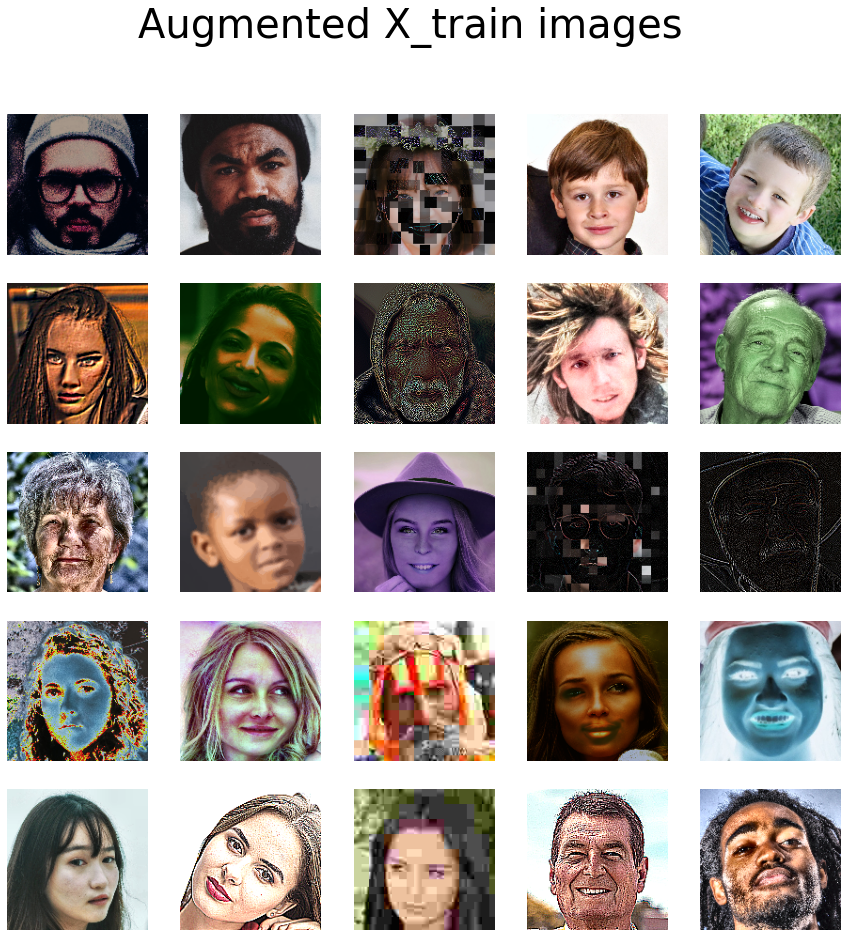

In [1053]:
Universal().plot_samples(images_aug,25,5,"Augmented X_train","x_train_aug");

In [1084]:
X_train_w_aug=np.concatenate((X_train,images_aug/255),axis=0)
y_train_w_aug=np.concatenate((y_train,y_train),axis=0)

In [1102]:
model_git=Sequential([
  # Add the preprocessing layers you created earlier.
  # resize_and_rescale,
  # data_augmentation,
  # layers.Conv2D(16, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # Rest of your model.
])
model_git.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_git.add(Conv2D(8, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_git.add(Conv2D(16, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_git.add(Conv2D(16, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_git.add(BatchNormalization())
model_git.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
model_git.add(Flatten())
model_git.add(Dropout(0.5))
model_git.add(Dense(16,kernel_regularizer =tf.keras.regularizers.l2(l=0.01)))
model_git.add(LeakyReLU(alpha=0.1))
model_git.add(Dropout(0.5))
model_git.add(Dense(1, activation = 'sigmoid'))
model_git.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
history_git=model_git.fit(X_train_w_aug, y_train_w_aug, batch_size = 128, epochs = 30, verbose = 1, validation_data = (X_val, y_val))


Epoch 1/30


2022-11-09 23:46:11.645630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 1.3640 - acc: 0.5012

2022-11-09 23:46:14.838609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 5s 104ms/step - loss: 1.3640 - acc: 0.5012 - val_loss: 0.9806 - val_acc: 0.5248
Epoch 2/30
26/26 [==============================] - 2s 70ms/step - loss: 1.0655 - acc: 0.5153 - val_loss: 0.9595 - val_acc: 0.5248
Epoch 3/30
26/26 [==============================] - 2s 66ms/step - loss: 1.0140 - acc: 0.5245 - val_loss: 0.9351 - val_acc: 0.5297
Epoch 4/30
26/26 [==============================] - 2s 67ms/step - loss: 0.9646 - acc: 0.5410 - val_loss: 0.9191 - val_acc: 0.5297
Epoch 5/30
26/26 [==============================] - 2s 66ms/step - loss: 0.9299 - acc: 0.5419 - val_loss: 0.9032 - val_acc: 0.5297
Epoch 6/30
26/26 [==============================] - 2s 66ms/step - loss: 0.9135 - acc: 0.5508 - val_loss: 0.8941 - val_acc: 0.5248
Epoch 7/30
26/26 [==============================] - 2s 66ms/step - loss: 0.8881 - acc: 0.5514 - val_loss: 0.8735 - val_acc: 0.5297
Epoch 8/30
26/26 [==============================] - 2s 67ms/step - loss: 0.8765 - acc: 0.5640

7/7 [==============================] - 0s 17ms/step


2022-11-09 23:47:09.365447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


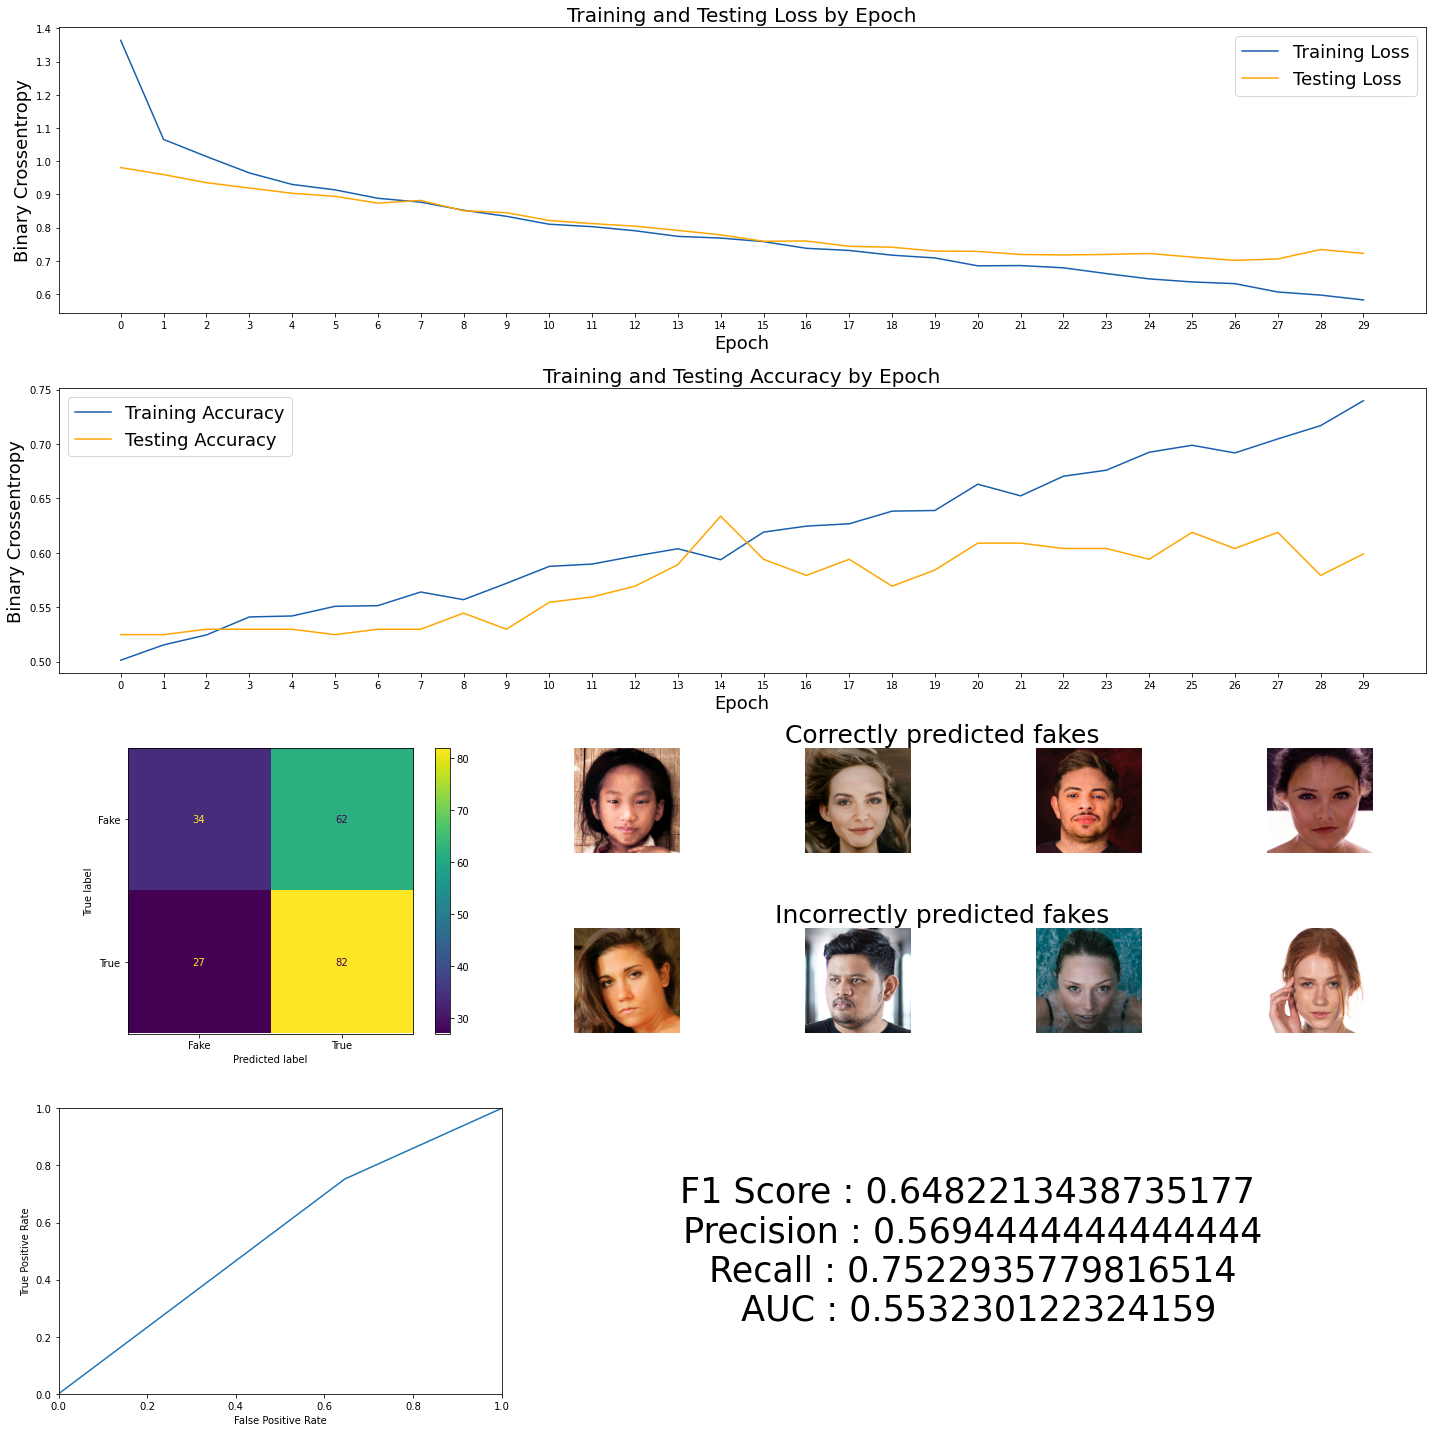

In [1103]:
Universal().plot_results_duo(history_git,model_git,X_test,y_test);